In [1]:
import pandas as pd
import numpy as np
import node2vec
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
routes_df = pd.read_csv('routes.csv')
routes_df = routes_df[['Source airport', 'Destination airport']]
routes_df = routes_df.dropna()

airports_df = pd.read_csv('airports.csv')
airports_df = airports_df[['IATA', 'ICAO', 'Latitude', 'Longitude']]
airports_df = airports_df.dropna()
airports_df = airports_df.drop_duplicates(subset=['IATA'])

source_airports_info = airports_df.rename(
    columns={'IATA': 'Source airport', 'Latitude': 'Source_Latitude', 'Longitude': 'Source_Longitude'}
)
destination_airports_info = airports_df.rename(
    columns={'IATA': 'Destination airport', 'Latitude': 'Dest_Latitude', 'Longitude': 'Dest_Longitude'}
)

merged_df = pd.merge(routes_df, source_airports_info[['Source airport', 'Source_Latitude', 'Source_Longitude']], on='Source airport', how='left')
merged_df = pd.merge(merged_df, destination_airports_info[['Destination airport', 'Dest_Latitude', 'Dest_Longitude']], on='Destination airport', how='left')

merged_df = merged_df.dropna(subset=['Source_Latitude', 'Source_Longitude', 'Dest_Latitude', 'Dest_Longitude'])

def haversine(lat1, lon1, lat2, lon2, earth_radius=6371):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = earth_radius * c
    return distance

# Calculate distance for each route
merged_df['Distance_km'] = merged_df.apply(
    lambda row: haversine(row['Source_Latitude'], row['Source_Longitude'],
                          row['Dest_Latitude'], row['Dest_Longitude']),
    axis=1
)

# Assign the result back to routes_df or use merged_df
routes_df['Distance_km'] = merged_df['Distance_km']

# Display the first few rows with the new distance column
print(routes_df.head())
print(f"Number of routes: {len(routes_df)}")
print(f"Routes with missing distances: {routes_df['Distance_km'].isnull().sum()}")

  Source airport Destination airport  Distance_km
0            AER                 KZN  1506.825604
1            ASF                 KZN  1040.438320
2            ASF                 MRV   448.164909
3            CEK                 KZN   770.508500
4            CEK                 OVB  1338.631467
Number of routes: 67663
Routes with missing distances: 729


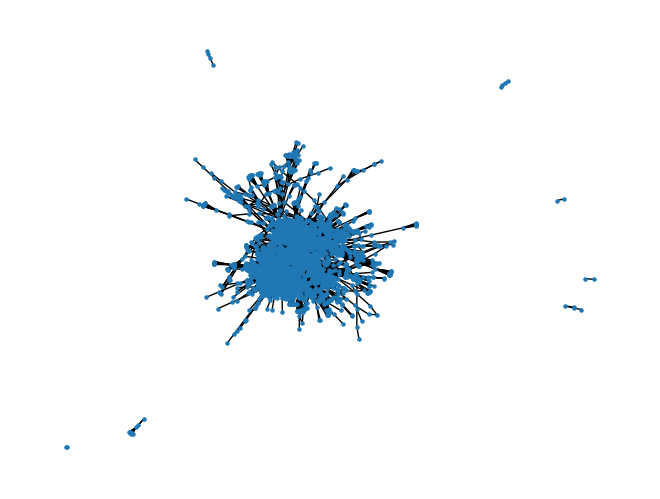

In [3]:
# Generate a graph from the routes DataFrame
G = nx.from_pandas_edgelist(routes_df, 'Source airport', 'Destination airport', ['Distance_km'])
# Convert to undirected graph
G = G.to_undirected()

# Show graph
nx.draw(G, with_labels=False, node_size=5, font_size=8)
plt.show()

C:\Users\locua\AppData\Local\Temp\ipykernel_30428\6010060.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)


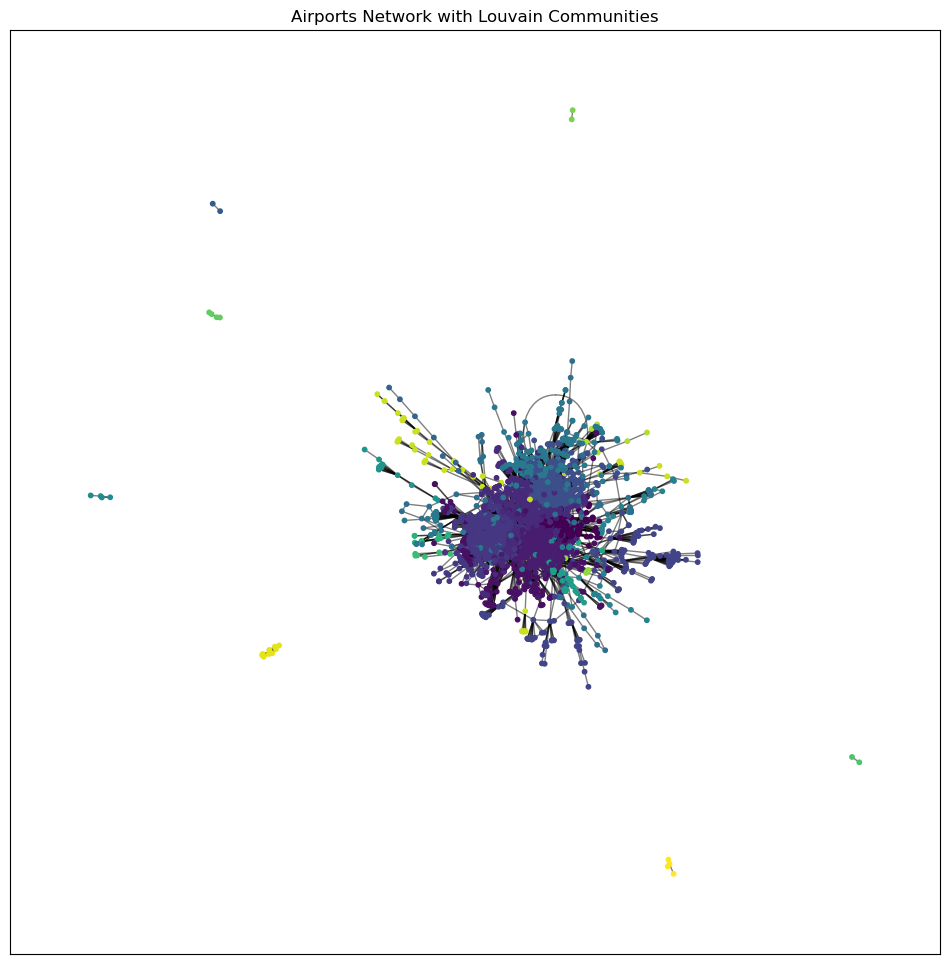

In [4]:
# Louvain community detection

from community import community_louvain
partition = community_louvain.best_partition(G)

# Draw the graph with communities
pos = nx.spring_layout(G)
plt.figure(figsize=(12, 12))
cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=10,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
#nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')
plt.title('Airports Network with Louvain Communities')
plt.show()
